作法
1. 整理user評book的序列壓扁
2. 整理book被user評的序列壓扁
3. 依據(ISBN,被user看過的01序列)做autoencoder
    + pytorch
        + 我暫令class叫做DEV,DEV_MODULE
    + 書只選被評過$\geq2$次
        + 143511本書
    + 其中user僅限看過1000本書以上，否則train不出來...
        + 117維向量
    + 參數：壓成16維向量、激發SELU、優化器Adam
4. 把以上特徵整理起來用lightgbm
    + `regression_l1` 採取MAE error
    + 我從網路上複製了random forest的參數代進去
        + gradient boost decision tree理論上滿需要調參的，瘋狂CV之類
    + 對不起我忘了現在最高分的submission是哪一次train的QQ
    + 我也有用pytorch寫fully connected但是train不起來，放棄

結論
1. 寫得非常亂對不起QQQ
    + 以後把特徵轉換整理成class這方面應該會改善很多
2. 一定要系統化調參，這太重要了QQQQQ

# df_total

In [1]:
import numpy as np
import pandas as pd
from learning2read.utils import DataLoader
DATA_PATH=r"/tmp2/b04303128/data/"
CODE_PATH=r"~/mlfinal/"
def Data(key,**kwargs):
    return DataLoader(DATA_PATH).load(key,**kwargs)
raw_user=Data("user")
raw_book=Data("books")
raw_train=Data("brtrain")
raw_test=Data("brtest")
raw_implicit=Data("brimplicit")
raw_submit=Data("submit",index_col=None,header=None)
df_test_neg1=raw_test.copy()
df_test_neg1['Book-Rating']=-1 # scalar as column
df_total=pd.concat([raw_train,raw_implicit,df_test_neg1],axis=0)
print(df_total.shape)
df_total.sample(5)

/tmp2/b04303128/data/users.csv
/tmp2/b04303128/data/books.csv
/tmp2/b04303128/data/book_ratings_train.csv
/tmp2/b04303128/data/book_ratings_test.csv
/tmp2/b04303128/data/implicit_ratings.csv
/tmp2/b04303128/data/submission.csv


/tmp2/b04303128/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:16: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  app.launch_new_instance()


(1149780, 3)


Book-Rating        ISBN     User-ID
169480            0  3570200000  521a0ff787
64030             7  0671319639  6cda14b0bc
29898             1  0394620305  e805eac663
180160            0  0446517127  08fe4c898c
14522            -1  067976402X  b1295c4eb1

In [2]:
dfg_user=df_total.groupby('User-ID')
gdf_user=dfg_user.agg({'Book-Rating':['count','min','max']})
gdf_user.columns=['count','min','max'] # cancel multilevel index
gdf_user_gte10=gdf_user.loc[gdf_user['count']>=1000,'count'].sort_values(ascending=False)
# gdf_user_gte10=gdf_user.loc[gdf_user['count']>=500,'count'].sort_values(ascending=False)
print(len(gdf_user_gte10))
gdf_user_gte10[:5]

117


User-ID
188ec05cf3    13602
58a34dcfe5     7550
91a5b876c9     6109
997dc62862     5891
67a302acdf     5850
Name: count, dtype: int64

# The "Book Vector"

In [3]:
gdf_book=df_total.groupby('ISBN').agg({'User-ID':'count'})
gdf_book.columns=['count']
gdf_book=gdf_book.loc[gdf_book['count']>=2,:] # cut
# gdf_book=gdf_book.loc[gdf_book['count']>=300,:] # cut2
gdf_book=gdf_book.sort_values('count',ascending=False)
dim1=len(gdf_book.index)
dim2=len(gdf_user_gte10.index)
dim1,dim2

(143511, 117)

In [4]:
from collections import defaultdict
user_vector_id = defaultdict(lambda: -1)
book_id = defaultdict(lambda: -1)
i=0
for x in gdf_user_gte10.index:
    user_vector_id[x] = i
    i+=1
i=0
for x in gdf_book.index:
    book_id[x]=i
    i+=1

index_list = []
for r in df_total.to_dict('record'):
    uid = user_vector_id[r['User-ID']]
    bid = book_id[r['ISBN']]
    if uid>=0 and bid>=0:
        index_list.append([bid,uid])

In [5]:
import torch
index_tns=torch.LongTensor(index_list).t()
value_tns=torch.ones(index_tns.size(1))
train_tns=torch.sparse.FloatTensor(index_tns, value_tns, torch.Size([dim1,dim2]))

In [6]:
# damm loss function = =
train_tns=train_tns.to_dense()

# AutoEncoder

In [7]:
import torch
from torch.autograd import Variable
import torch.nn as nn
import datetime
now=datetime.datetime.now

def pow2_list(a,b): # a>b
    m = 1
    while m<=b:
        m *= 2
    rlist = [m] # want m>b
    while m<=a:
        m *= 2
        rlist.append(m) # want m<=a
    return rlist
class DEV_MODULE(nn.Module):
    def __init__(self, hyper_param):
        super(DEV_MODULE, self).__init__()
        encoder_units_list = []
        decoder_units_list = []
        p2l = pow2_list(hyper_param['x'].size(1),hyper_param['code_length'])
        for i in range(len(p2l)):
            if i==0:
                decoder_units_list.append([hyper_param['code_length'], p2l[i]])
            else:
                decoder_units_list.append([p2l[i-1], p2l[i]])
        decoder_units_list.append([p2l[-1], hyper_param['x'].size(1)])
        for upair in reversed(decoder_units_list):
            encoder_units_list.append([upair[1],upair[0]])
            
        encoder_layers = []
        decoder_layers = []
        for i,upair in enumerate(encoder_units_list):
            if i>0:
                encoder_layers.append(eval("nn.modules.activation.%s(True)"%hyper_param['activation']))
            encoder_layers.append(nn.Linear(upair[0], upair[1]))
        self.encoder = nn.Sequential(*encoder_layers)
        for i,upair in enumerate(decoder_units_list):
            if i>0:
                decoder_layers.append(eval("nn.modules.activation.%s(True)"%hyper_param['activation']))
            decoder_layers.append(nn.Linear(upair[0], upair[1]))
        decoder_layers.append(nn.modules.activation.ReLU(True))
        self.decoder = nn.Sequential(*decoder_layers)
    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

class DEV:
    def __init__(self,
                 code_length=2,
                 activation='ReLU' or 'SELU',
                 solver='Adam',
                 learning_rate=0.1,
                 random_seed=1):
        self.__dict__.update(locals())
        del self.self # fix locals
        self.module = None # build when "fit" is called
    def fit(self, x_train, iters=100): # x_train sparse
        torch.manual_seed(self.random_seed)
        if not isinstance(x_train,torch.Tensor):
            x_train = check_tensor_array(x_train)
        self.x = Variable(x_train)
        self.y = Variable(x_train) # AutoEncoder :)
        self.module=DEV_MODULE(self.__dict__)
        optimizer = eval("torch.optim.%s"%self.solver)(self.module.parameters(),lr=self.learning_rate)
        loss_func = torch.nn.MSELoss()
#         loss_func = torch.nn.BCELoss()

        
        st=now()
        for itr in range(iters):
            pred = self.module(self.x)
            loss = loss_func(pred, self.y)
            optimizer.zero_grad()   # clear gradients for next train
            loss.backward()         # backpropagation, compute gradients
            optimizer.step()        # apply gradients
            print(itr,loss,now()-st)
        return self
    def predict(self,x_test):
        if not isinstance(x_test,torch.Tensor):
            x_test = check_tensor_array(x_test)
        prediction = self.module.encoder(x_test)
        return prediction.data.numpy()

In [8]:
torch.get_num_threads(), train_tns.size()

(16, torch.Size([143511, 117]))

# Train!

In [9]:
model=DEV(code_length=16, activation='SELU', solver='Adam', learning_rate=0.01)
model.fit(train_tns,10)

0 tensor(1.00000e-02 *
       1.9668) 0:00:07.093442
1 tensor(1.00000e-02 *
       1.4114) 0:00:13.986118
2 tensor(1.00000e-02 *
       1.1424) 0:00:20.157533
3 tensor(1.00000e-02 *
       1.1042) 0:00:26.603290
4 tensor(1.00000e-02 *
       1.1011) 0:00:32.639640
5 tensor(1.00000e-02 *
       1.0540) 0:00:39.220979
6 tensor(1.00000e-02 *
       1.0663) 0:00:45.787393
7 tensor(1.00000e-02 *
       1.0534) 0:00:52.024123
8 tensor(1.00000e-02 *
       1.0335) 0:00:58.655084
9 tensor(1.00000e-02 *
       1.0203) 0:01:05.082682


In [ ]:
import seaborn
code=model.predict(train_tns)
code_df=pd.DataFrame(code).iloc[:,:]

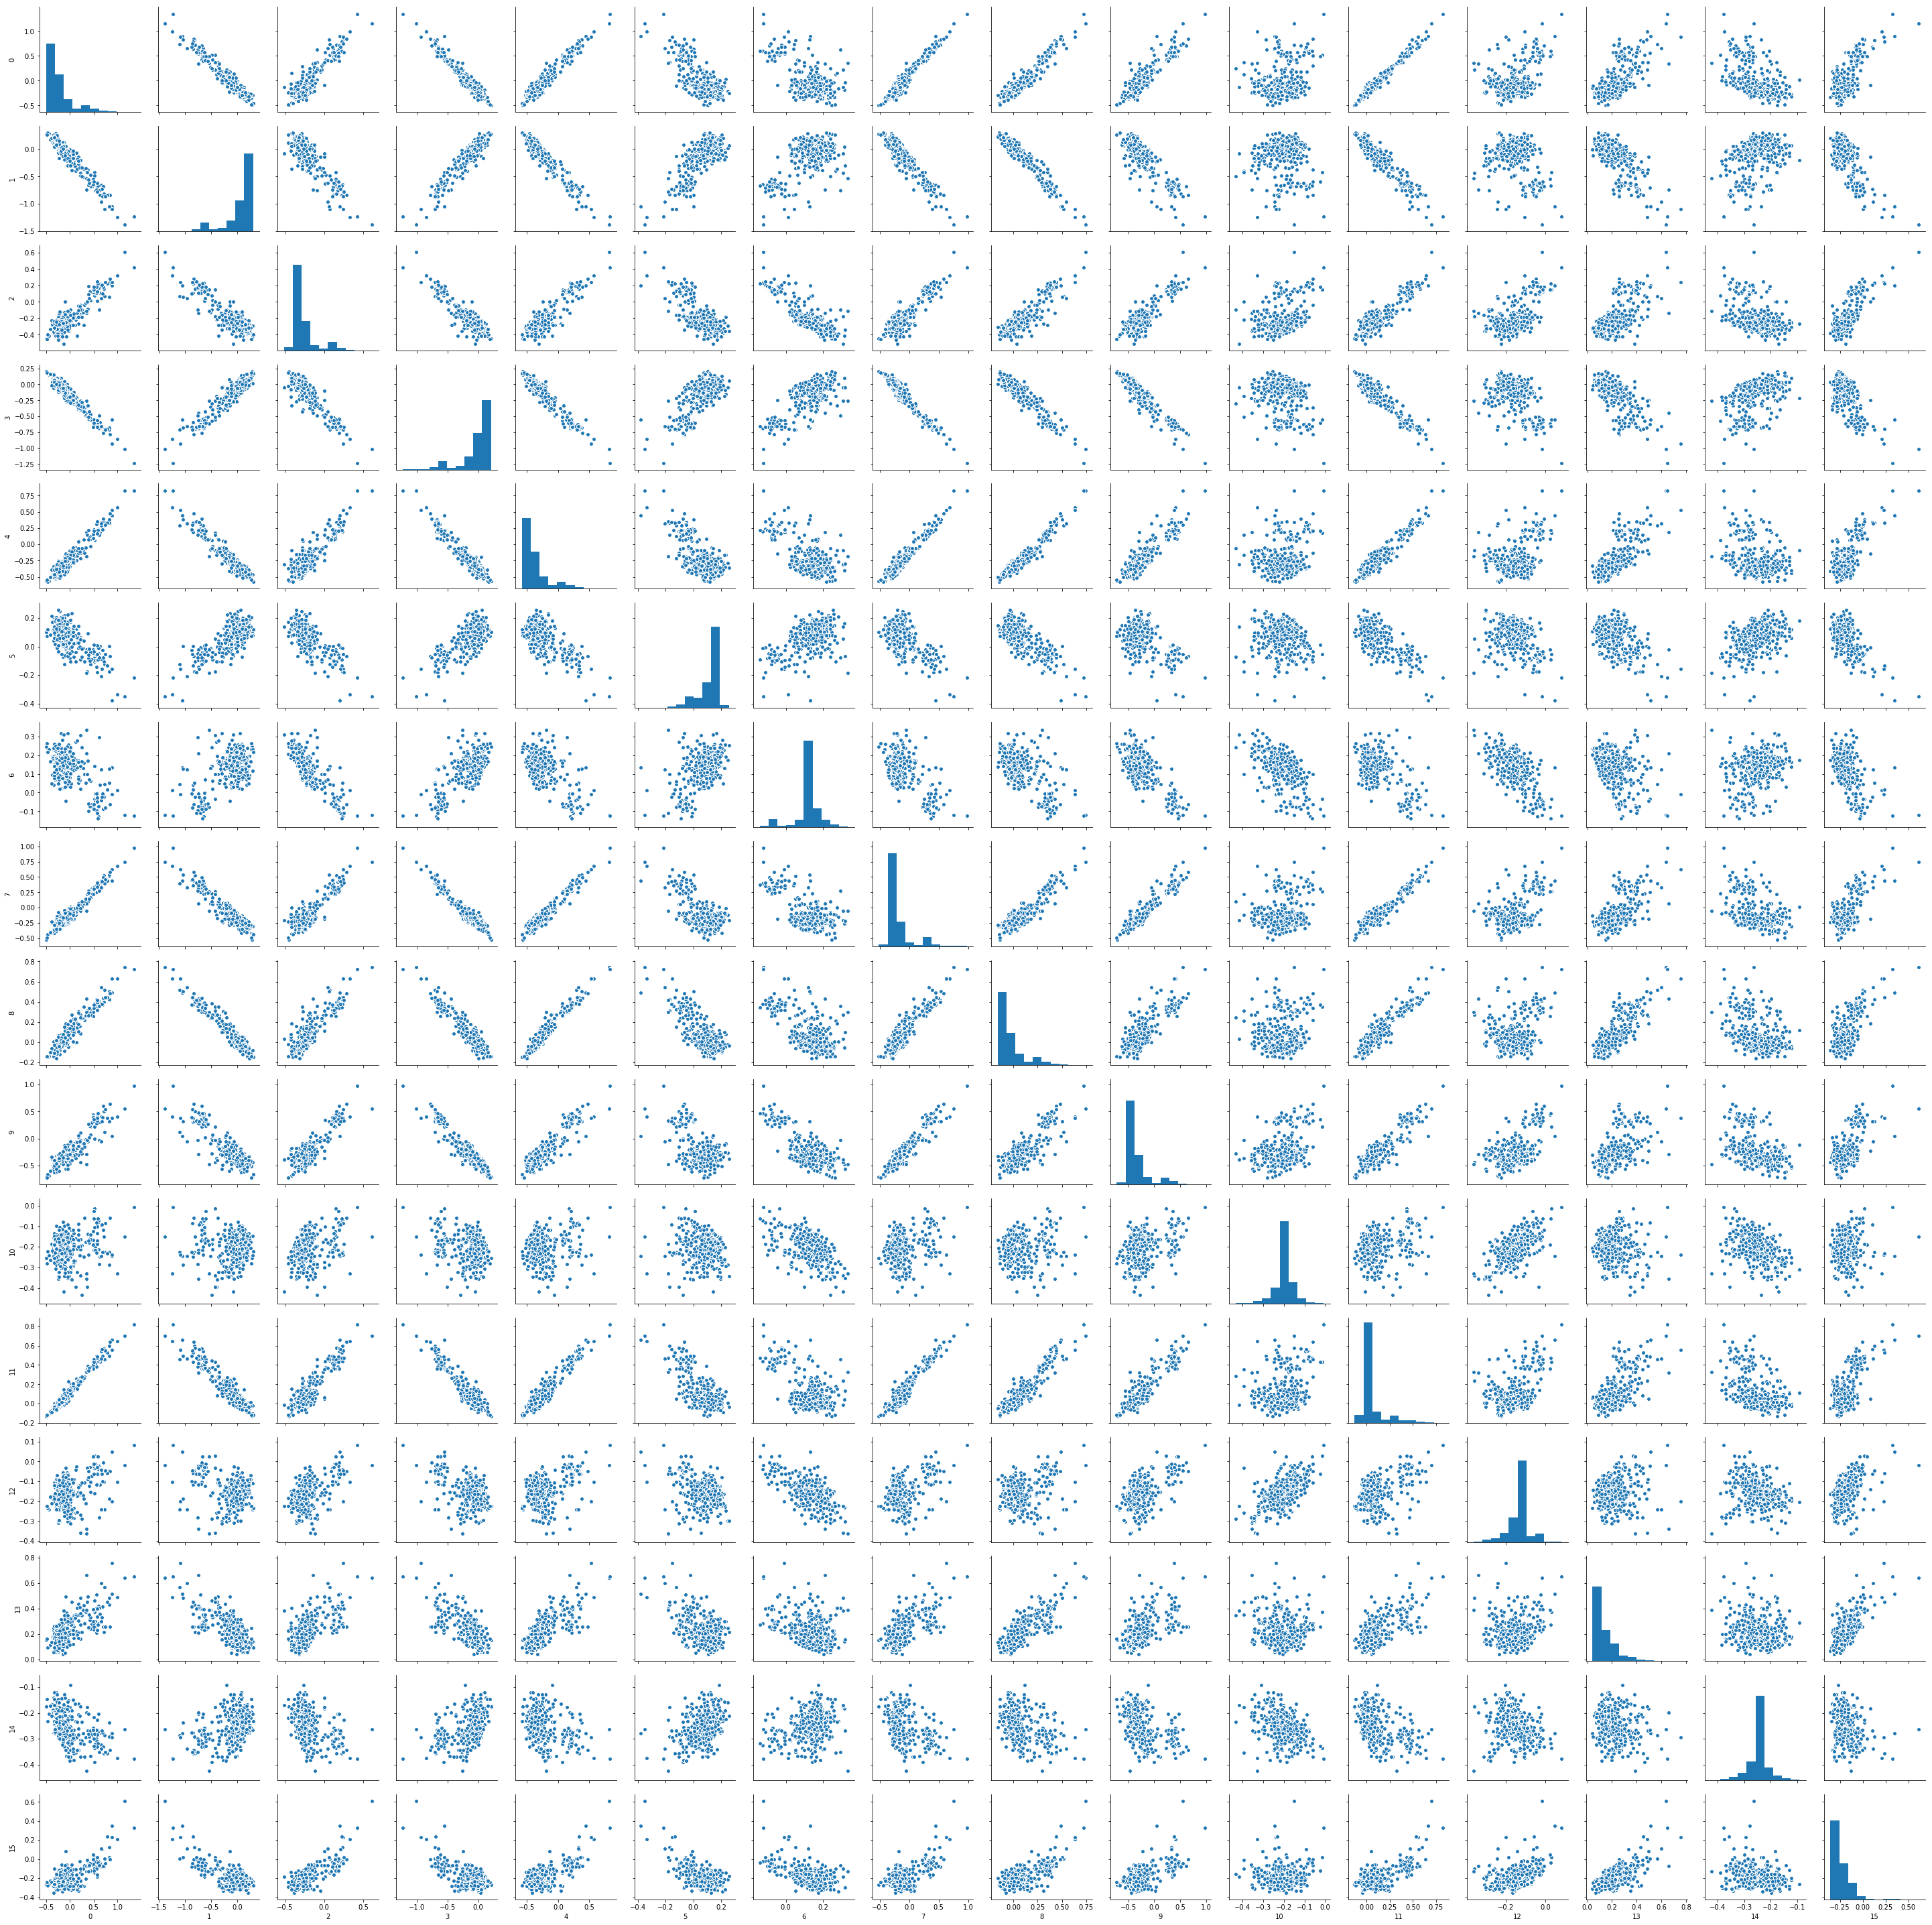

In [12]:
seaborn.pairplot(code_df.sample(1000))

code長度16的靜態圖：
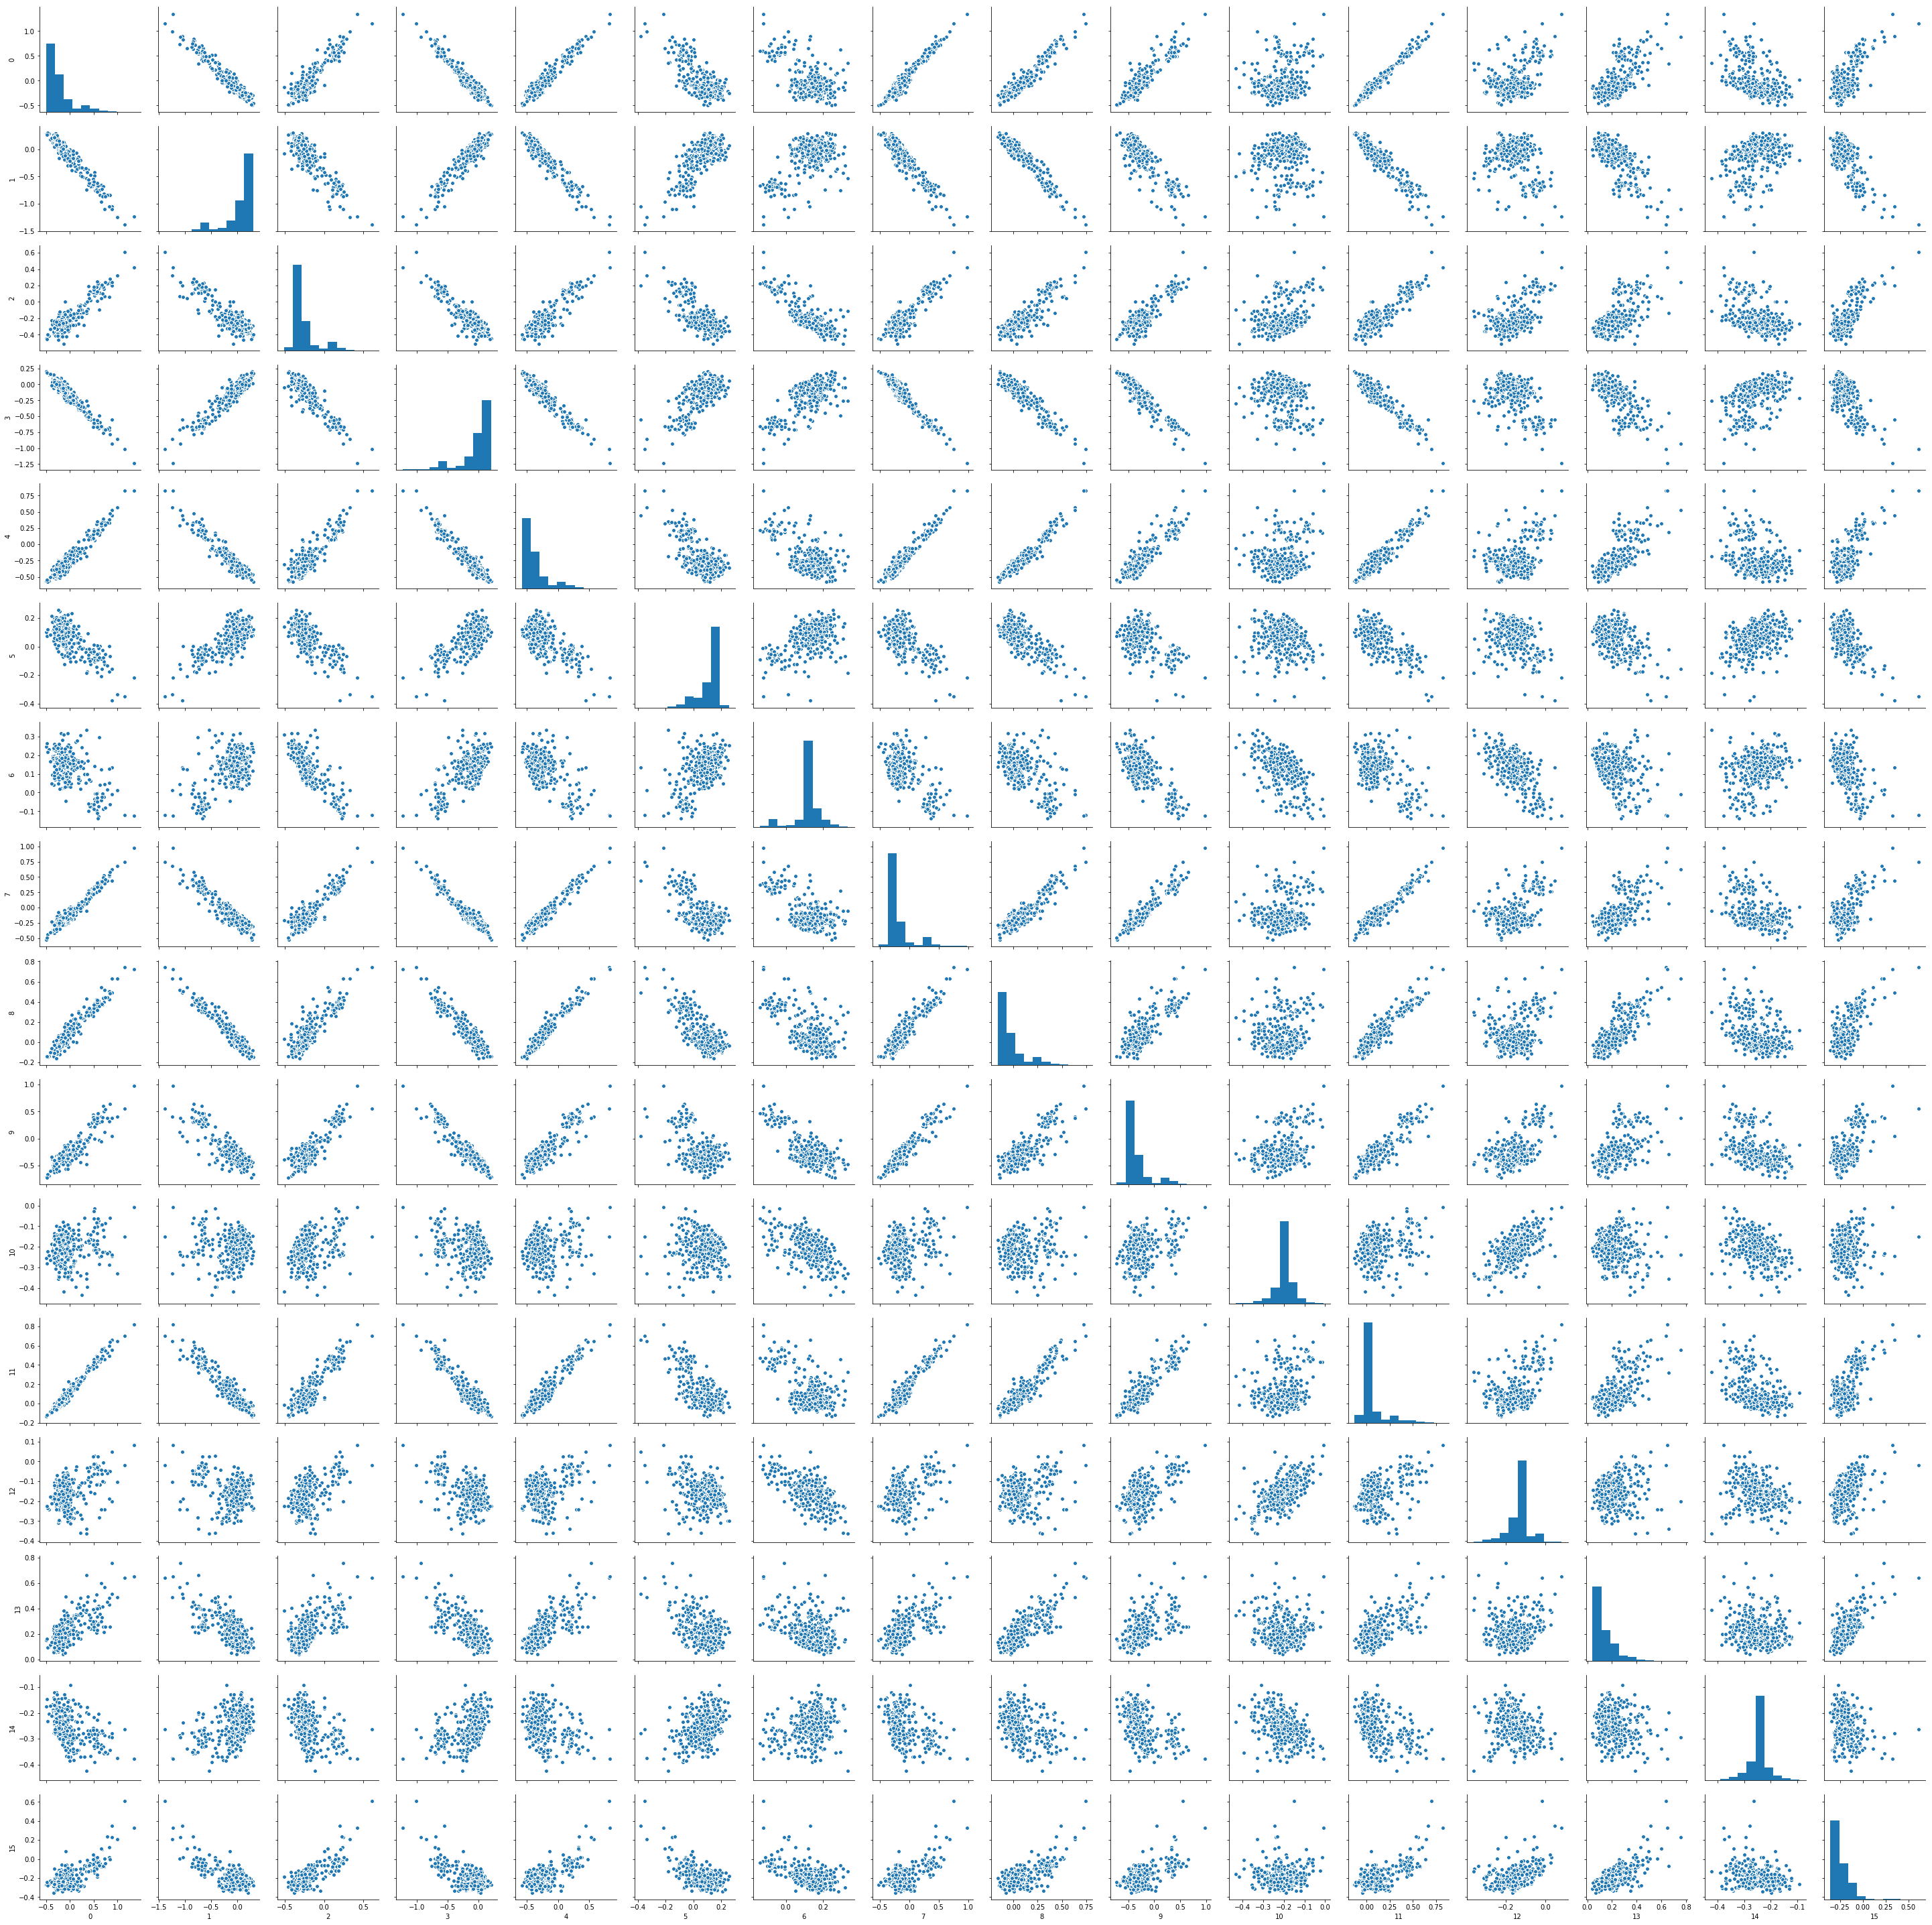

# Mapping ISBN & Book Vectors

In [13]:
zero_book_vec=model.predict(torch.zeros(dim2))

In [14]:
df_book_vec_lst = []
x=df_total['ISBN']
df_book_index=x.unique()
for isbn in df_book_index:
    bid=book_id[isbn]
    if bid<0:
        df_book_vec_lst.append(zero_book_vec)
    else:
        df_book_vec_lst.append(code[book_id['0743458621']])
df_book_vec = pd.concat([pd.DataFrame(df_book_index, columns=['ISBN']),
                         pd.DataFrame(df_book_vec_lst)],axis=1)
df_book_vec.sample(5)

ISBN         0         1         2         3         4  \
4707    0671024345 -0.272648  0.164400 -0.328873  0.038847 -0.422335   
209293  8475805418 -0.319060  0.216419 -0.320224  0.063367 -0.458795   
287038  0874776678 -0.319060  0.216419 -0.320224  0.063367 -0.458795   
3901    0440509238 -0.272648  0.164400 -0.328873  0.038847 -0.422335   
237352  0821766171 -0.272648  0.164400 -0.328873  0.038847 -0.422335   

               5         6         7         8         9        10        11  \
4707    0.125718  0.155262 -0.263754 -0.096027 -0.397393 -0.174488  0.002403   
209293  0.138617  0.139969 -0.287043 -0.107397 -0.402719 -0.188312 -0.031076   
287038  0.138617  0.139969 -0.287043 -0.107397 -0.402719 -0.188312 -0.031076   
3901    0.125718  0.155262 -0.263754 -0.096027 -0.397393 -0.174488  0.002403   
237352  0.125718  0.155262 -0.263754 -0.096027 -0.397393 -0.174488  0.002403   

              12        13        14        15  
4707   -0.124253  0.102863 -0.236648 -0.240794  
209293 -0.121791  0.090441 -0.231874 -0.263358  
287038 -0.121791  0.090441 -0.231874 -0.263358  
3901   -0.124253  0.102863 -0.236648 -0.240794  
237352 -0.124253  0.102863 -0.236648 -0.240794

# Book Rating(4001衍生)

In [ ]:
from collections import defaultdict
book_rate_dict = defaultdict(lambda: {'nuser':0,'ratings':[]})
for r in raw_train.to_dict('record'):
    isbn=r['ISBN']
    book_rate_dict[isbn]['nuser']+=1
    book_rate_dict[isbn]['ratings'].append(r['Book-Rating'])

In [ ]:
import scipy.stats
stat_name=['mode','tmean','tmin','tmax','skew','kurtosis']
def gen(bid,r):
    result={
        'ISBN':bid,
        'nuser':r['nuser']
    }
    for name in stat_name:
        result["brating_"+name]=eval("scipy.stats.%s(r['ratings'])"%name)
    for v in range(9):
        q=(v+1)*10
        result['brating_q%d'%(v+1)]=np.percentile(r['ratings'],q)
    return result
df_book_rate=pd.DataFrame([gen(bid,r) for bid,r in book_rate_dict.items()])
df_book_rate['brating_mode']=df_book_rate['brating_mode'].apply(lambda r:r[0][0])
df_book_rate.sample(3)

In [ ]:
df_book_rate.sample(3)

In [ ]:
df_book=df_book_vec.iloc[:,:]
df_book=df_book.merge(df_book_rate,on='ISBN',how='left')
df_book=df_book.fillna(df_book.median())
df_book.sample(3)

# User Rating (4001)

In [ ]:
user_dict={}
def new_user(uid):
    global user_dict
    user_dict[uid]={'nbook':0,'ratings':[]}
for r in raw_train.to_dict('record'):
    uid=r['User-ID']
    if not user_dict.get(uid):
        new_user(uid)
    user_dict[uid]['nbook']+=1
    user_dict[uid]['ratings'].append(r['Book-Rating'])

In [ ]:
import scipy.stats
stat_name=['mode','tmean','tmin','tmax','skew','kurtosis']
def gen(uid,r):
    result={
        'User-ID':uid,
        'nbook':r['nbook']
    }
    for name in stat_name:
        result["rating_"+name]=eval("scipy.stats.%s(r['ratings'])"%name)
    for v in range(9):
        q=(v+1)*10
        result['rating_q%d'%(v+1)]=np.percentile(r['ratings'],q)
    return result
df_user_rate=pd.DataFrame([gen(uid,r) for uid,r in user_dict.items()])
df_user_rate['rating_mode']=df_user_rate['rating_mode'].apply(lambda r:r[0][0])
df_user_rate.sample(3)

# Prepare Training

In [ ]:
def rating_merge(rating,user,book): # only users.csv, books disposed
    df=rating
    df=df.merge(user,on='User-ID',how='left')
    df=df.merge(book,on='ISBN',how='left')
    df=df.drop(['User-ID','ISBN'],1)
    df=df.fillna(df.median()) # fill with median
    return df
df_train=rating_merge(raw_train,df_user_rate,df_book)
df_train.sample(10)

# LightGBM

In [ ]:
x_train=df_train.iloc[:,1:]
y_train=np.ravel(df_train.iloc[:,:1])

In [ ]:
import lightgbm as lgb
# random forest mode
param = {'num_leaves':300,
'max_depth':-1,
'learning_rate':0.01,
"min_child_samples":20,
"boosting":"rf",
"feature_fraction":0.4,
"bagging_freq":10,
"bagging_fraction":0.4 ,
"bin_construct_sample_cnt":200000,
"bagging_seed": 11}
model=lgb.LGBMRegressor(
    objective='regression_l1',
    **param
)
model.fit(x_train, y_train)
model.score(x_train, y_train) # best: 0.33981505052378735

# Fully Connected Neural Network

In [ ]:
# import torch
# from torch.autograd import Variable
# import torch.nn.functional as F
# # from sklearn.utils import check_array

# def check_array(array_like_object):
#     return np.array(array_like_object)
# def check_tensor(array_like_object):
#     return torch.from_numpy(array_like_object).float() # cause GPU does float faster
# def check_tensor_array(array_like_object):
#     return check_tensor(check_array(array_like_object))
# class DEV_MODULE(torch.nn.Module):
#     def __init__(self, n_feature, n_output, build_param):
#         super(DEV_MODULE, self).__init__()
#         self.units = build_param['units']
#         self.layers = build_param['layers']
#         self.activation = eval("F.%s"%build_param['activation'])
        
#         n_hidden_out = self.units
#         for i in range(self.layers):
#             n_hidden_in = self.units if i>0 else n_feature
# #             self['hidden%03d'%(i+1)] = torch.nn.Linear(n_hidden_in, n_hidden_out)
#             self.add_module('hidden%03d'%(i+1), torch.nn.Linear(n_hidden_in, n_hidden_out))
#         self.predict = torch.nn.Linear(n_hidden_out, n_output)

#     def forward(self, x):
#         for i in range(self.layers):
#             # x(l=3,i) = relu(s(l=3,i)) , with s(l=3,i)=[w(l=3)][x(l=2)]
#             x = self.activation(self.__getattr__('hidden%03d'%(i+1))(x))
#         x = self.predict(x) # linear output
#         return x

# class DEV:
#     def __init__(self,layers=4,units=3,activation='relu',learning_rate=0.1):
#         self.module = None # build when "fit" is called
#         self.layers = layers
#         self.units = units
#         self.activation = activation
#         self.learning_rate=learning_rate
#     def fit(self,x_train,y_train,iters=3):
#         x_train = check_array(x_train)
#         y_train = check_array(y_train)
#         self.x_tensor = Variable(check_tensor(x_train))
#         n_sample = self.x_tensor.size(0)
#         self.x_tensor = self.x_tensor.view(n_sample, -1)
#         n_feature = self.x_tensor.size(1)
#         self.y_tensor = Variable(check_tensor(y_train).view(n_sample,-1))
#         n_output = self.y_tensor.size(1)
#         self.module=DEV_MODULE(n_feature=n_feature,
#                                n_output=n_output,
#                                build_param=self.__dict__)
#         self.optimizer = torch.optim.Adam(self.module.parameters(),
#                                     lr=self.learning_rate)
#         self.loss_func = torch.nn.L1Loss()  # this is for regression mean squared loss
        
#         for itr in range(iters):
#             self.prediction = self.module(self.x_tensor)     # input x and predict based on x

#             self.loss = self.loss_func(self.prediction, self.y_tensor)     # must be (1. nn output, 2. target)

#             self.optimizer.zero_grad()   # clear gradients for next train
#             self.loss.backward()         # backpropagation, compute gradients
#             self.optimizer.step()        # apply gradients
#             print(itr,self.loss)
            
#         return self
#     def predict(self,x_test):
#         x_test_tensor = check_tensor_array(x_test)
#         prediction = self.module(x_test_tensor)
#         return prediction.data.numpy()
        
# model = DEV(28,6,'selu',learning_rate=0.01)
# model.fit(x_train,y_train,50) # best ein=1.4511

# Output Prediction

In [ ]:
x_test=rating_merge(raw_test,df_user_rate,df_book)
def output_test(est_name="empty"):
    y_test_predict=model.predict(x_test)
    y_test_predict=pd.DataFrame(y_test_predict)
    y_test_predict.describe()

    df_output=raw_submit.iloc[:,:]
    df_output.iloc[:,0]=y_test_predict
    
    df_output2=df_output.iloc[:,:]
    df_output2=df_output2.round(1)
    df_output2.to_csv(
        Path(CODE_PATH).joinpath("track2_%s.csv"%est_name),
        header=None,index=None)
    print(df_output.describe())
    df_output=df_output.round()
    df_output=df_output.astype('int32')
    df_output.to_csv(
        Path(CODE_PATH).joinpath("track1_%s.csv"%est_name),
        header=None,index=None)
    print(df_output.describe())
    return df_output,df_output2
# output_test("gbm_default_1.5down")

df1,df2=output_test("usrRate_bookVec_bookRate_gbm_rf_v2")

# RESULT #
"""

"""
pass